# BLIP VQA Labeled Test
## True/False 비율 기반 랜드마크 인식 평가

기존의 YES 비율 평가에서 개선하여, 각 질문마다 예상 답변(yes/no)을 라벨링하고
BLIP 모델의 답변이 예상과 일치하는지 True/False로 평가합니다.

In [1]:
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering
from PIL import Image
import glob
import os
import json
from tqdm.auto import tqdm

# GPU 사용 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# 모델 로드
model_name = "ybelkada/blip-vqa-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForQuestionAnswering.from_pretrained(model_name).to(device)

print(f"BLIP 모델 로드 완료. (사용 장치: {device})")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

BLIP 모델 로드 완료. (사용 장치: cuda)


In [2]:
# 로컬/서버에서 실행할 땐 아래 코드 주석처리 하세요
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os

# --- 1. 환경별 프로젝트 루트 경로 정의 ---
# (경로 1: Google Drive Mount Colab)
COLAB_DRIVE_ROOT = "/content/drive/Othercomputers/내 컴퓨터/데이콘 출판마을 프로젝트/github"
# (경로 2: "서버" 또는 다른 Colab 환경)
SERVER_ROOT = "/content/group5_project"

# --- 2. 환경 감지 및 PROJECT_ROOT 설정 ---
if os.path.exists(COLAB_DRIVE_ROOT):
    PROJECT_ROOT = COLAB_DRIVE_ROOT
    print(f"환경 감지: Google Drive Colab")
elif os.path.exists(SERVER_ROOT):
    PROJECT_ROOT = SERVER_ROOT
    print(f"환경 감지: Server (group5_project)")

# --- 3. 최종 DATA_DIR 설정 ---
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
print(f"최종 DATA_DIR: {DATA_DIR}")

# --- 4. 파일 경로 설정 ---
LANDMARK_QA_LABELED_FILE = os.path.join(DATA_DIR, "landmark_qa_labeled.json")
print(f"JSON 파일 경로: {LANDMARK_QA_LABELED_FILE}")

환경 감지: Google Drive Colab
최종 DATA_DIR: /content/drive/Othercomputers/내 컴퓨터/데이콘 출판마을 프로젝트/github/data
JSON 파일 경로: /content/drive/Othercomputers/내 컴퓨터/데이콘 출판마을 프로젝트/github/data/landmark_qa_labeled.json


In [4]:
# landmark_qa_labeled.json 로드
with open(LANDMARK_QA_LABELED_FILE, 'r', encoding='utf-8') as f:
    labeled_qa_data = json.load(f)
    print(f"Labeled Q&A data loaded from '{LANDMARK_QA_LABELED_FILE}'.")

# 데이터 확인
for landmark, qa_list in labeled_qa_data.items():
    print(f"\n{landmark}: {len(qa_list)}개 질문")
    print(f"  예시: {qa_list[0]}")

Labeled Q&A data loaded from '/content/drive/Othercomputers/내 컴퓨터/데이콘 출판마을 프로젝트/github/data/landmark_qa_labeled.json'.

활판공방 인쇄기: 40개 질문
  예시: ['Is the main object a sculpture?', 'yes']

활돌이: 40개 질문
  예시: ['Is the main object a statue?', 'yes']

지혜의숲 고양이: 40개 질문
  예시: ['Is the main object a sculpture?', 'yes']

네모탑: 40개 질문
  예시: ['Is the main object a sculpture?', 'yes']

지혜의숲 조각상: 40개 질문
  예시: ['Is the main object a sculpture?', 'yes']


In [163]:
labeled_qa_data = {
  "마법천자문 손오공": [
    ["Is the main object a statue?", "yes"],
    ["Is the statue located outdoors?", "yes"],
    ["Is the statue human-shaped?", "yes"],
    ["Is the statue a boy character?", "yes"],
    ["Is the statue's clothing purple?", "yes"],
    ["Is the statue wearing a yellow belt?", "yes"],
    ["Is the statue's hair red?", "yes"],
    ["Does the statue have spiky hair?", "yes"],
    ["Does the statue have a headband?", "yes"],
    ["Is the headband yellow?", "yes"],
    ["Does the statue have a tail?", "yes"],
    ["Is the tail red?", "yes"],
    ["Is the statue in a standing position?", "yes"],
    ["Does the statue have two distinct legs?", "yes"],
    ["Does the statue have human-like ears?", "yes"],
    ["Is the statue raising its right arm?", "yes"],
    ["Is the statue's hair shaped like flames?", "yes"],
    ["Does the statue have a smiling face?", "yes"],
    ["Is the statue wearing shoes?", "yes"],
    ["Are the statue's shoes purple?", "yes"],

    ["Is the statue's main color pink?", "no"],
    ["Is the statue holding a blue rectangular block?", "no"],
    ["Does the statue have a single fin on its head?", "no"],
    ["Is the statue's body round and plump?", "no"],
    ["Is the statue holding an object with its left arm?", "no"],
    ["Is the statue's base blue?", "no"],
    ["Is the main object an airplane?", "no"],
    ["Is the main object a piece of fruit?", "no"],
    ["Is this a picture of a car?", "no"],
    ["Is this a boat on the water?", "no"],
    ["Is the object a tree?", "no"],
    ["Is this a picture of a computer?", "no"],
    ["Is the object flying in the sky?", "no"],
    ["Is the object a musical instrument?", "no"],
    ["Is the object on fire?", "no"],
    ["Is the object a real, living animal?", "no"],
    ["Is the sculpture an owl?", "no"],
    ["Is the sculpture made of rusted metal?", "no"],
    ["Is the sculpture covered in ivy?", "no"],
    ["Is the sculpture a cat?", "no"]
  ],
  "로드킬 부엉이": [
    ["Is the main object a sculpture?", "yes"],
    ["Is the sculpture located indoors?", "yes"],
    ["Is the sculpture inside a display case?", "yes"],
    ["Is the display case transparent (clear)?", "yes"],
    ["Is the sculpture standing on a white pedestal?", "yes"],
    ["Is the sculpture an animal?", "yes"],
    ["Is the animal a bird?", "yes"],
    ["Is the bird an owl?", "yes"],
    ["Does the owl have large, round eyes?", "yes"],
    ["Does the owl have a head?", "yes"],
    ["Does the owl have a body?", "yes"],
    ["Is the owl's body covered in a feathered texture?", "yes"],
    ["Are the feathers layered?", "yes"],
    ["Is the sculpture sitting on a base?", "yes"],
    ["Is the base made of tires?", "yes"],
    ["Is the base black?", "yes"],
    ["Are the tires stacked?", "yes"],
    ["Is the sculpture dark in color (brown, grey, black)?", "yes"],
    ["Does the sculpture have a beak?", "yes"],
    ["Does the sculpture have a textured surface?", "yes"],

    ["Is the main object an airplane?", "no"],
    ["Is the main object a piece of fruit?", "no"],
    ["Is the main object a food dish?", "no"],
    ["Is this a picture of a car?", "no"],
    ["Is this a boat on the water?", "no"],
    ["Is the object a tree?", "no"],
    ["Is this a picture of a computer?", "no"],
    ["Is the main object a person running?", "no"],
    ["Is the object flying in the sky?", "no"],
    ["Is the object a musical instrument?", "no"],
    ["Is the object a table?", "no"],
    ["Is the object a chair?", "no"],
    ["Is this a picture of a road?", "no"],
    ["Is the object a cell phone?", "no"],
    ["Is the object a kitchen appliance?", "no"],
    ["Is the object a bridge?", "no"],
    ["Is the object on fire?", "no"],
    ["Is the object a planet?", "no"],
    ["Is the object a mountain?", "no"],
    ["Is the object a real, living animal?", "no"]
  ],
  "나남출판사": [
    ["Is the main object a building?", "yes"],
    ["Is the building located outdoors?", "yes"],
    ["Are the walls of the building covered in plants?", "yes"],
    ["Are the plants covering the walls ivy?", "yes"],
    ["Do the plants climb up the building's walls?", "yes"],
    ["Is the wall covered in many small leaves?", "yes"],
    ["Does the ivy form a dense covering on the wall?", "yes"],
    ["Are there vines visible on the wall?", "yes"],
    ["Are the leaves on the walls multi-colored?", "yes"],
    ["Are there green leaves on the walls?", "yes"],
    ["Are there leaves on the walls?", "yes"],
    ["Is the building's surface textured by the leaves?", "yes"],
    ["Is the building opaque (not transparent)?", "yes"],
    ["Are the leaves growing on the building?", "yes"],
    ["Is the building's wall a vertical surface?", "yes"],
    ["Are there thousands of leaves visible?", "yes"],
    ["Is the building a work of architecture?", "yes"],
    ["Is the ground visible at the bottom of the building?", "yes"],
    ["Does the building have a roof?", "yes"],
    ["Is the building static (not moving)?", "yes"],

    ["Is the main object an animal?", "no"],
    ["Is the main object a piece of fruit?", "no"],
    ["Is the main object a food dish?", "no"],
    ["Is this a picture of a computer?", "no"],
    ["Is the object a musical instrument?", "no"],
    ["Is the object a table?", "no"],
    ["Is the object a chair?", "no"],
    ["Is the object a cell phone?", "no"],
    ["Is the object a kitchen appliance?", "no"],
    ["Is the object on fire?", "no"],
    ["Is the object a planet?", "no"],
    ["Is the object a real, living animal?", "no"],
    ["Is the object a toy?", "no"],
    ["Is the object a book?", "no"],
    ["Is the object a boat?", "no"],
    ["Is the object flying in the sky?", "no"],
    ["Is the object in the water?", "no"],
    ["Is the object a tool?", "no"],
    ["Is the object a weapon?", "no"],
    ["Is this a picture of the sky at night?", "no"]
  ],
  "활판공방 인쇄기": [
    ["Is the main object a sculpture?", "yes"],
    ["Is the sculpture located outdoors?", "yes"],
    ["Is the sculpture made of metal?", "yes"],
    ["Does the sculpture appear old and rusted?", "yes"],
    ["Does the sculpture look like a large machine?", "yes"],
    ["Does the sculpture resemble a printing press?", "yes"],
    ["Is the sculpture complex and mechanical?", "yes"],
    ["Does the sculpture have many gears?", "yes"],
    ["Does the sculpture have rollers?", "yes"],
    ["Are there many small metal pieces on the sculpture?", "yes"],
    ["Are the small metal pieces clustered together?", "yes"],
    ["Are the small metal pieces in a large pile?", "yes"],
    ["Is the sculpture standing on a platform?", "yes"],
    ["Is the platform gray?", "yes"],
    ["Is the top surface of the platform a metal grate?", "yes"],
    ["Is the sculpture dark in color?", "yes"],
    ["Is the sculpture's texture rough?", "yes"],
    ["Is the sculpture reddish-brown in color?", "yes"],
    ["Is the main body of the sculpture rectangular?", "yes"],
    ["Are there buildings in the background?", "yes"],

    ["Is the sculpture a real, living animal?", "no"],
    ["Is the sculpture a plant?", "no"],
    ["Is the sculpture soft?", "no"],
    ["Is the sculpture covered in many bright colors?", "no"],
    ["Is the sculpture blue in color?", "no"],
    ["Is the sculpture white in color?", "no"],
    ["Is the sculpture made of wood?", "no"],
    ["Is the sculpture made of glass?", "no"],
    ["Is this a picture of a food dish?", "no"],
    ["Is the object a piece of fruit?", "no"],
    ["Is the object flying in the sky?", "no"],
    ["Is the object in the water?", "no"],
    ["Is the object a computer?", "no"],
    ["Is the object a toy?", "no"],
    ["Is the main object a person?", "no"],
    ["Is the sculpture wearing clothes?", "no"],
    ["Is the sculpture a boat?", "no"],
    ["Is the sculpture a car?", "no"],
    ["Is the sculpture a flower?", "no"],
    ["Is this a picture of a kitchen appliance?", "no"]
  ],
  "활돌이": [
    ["Is the main object a statue?", "yes"],
    ["Is the statue a cartoon character?", "yes"],
    ["Is the statue located outdoors?", "yes"],
    ["Is the statue's main color pink?", "yes"],
    ["Is the statue's body round and plump?", "yes"],
    ["Does the statue have a single fin on its head?", "yes"],
    ["Does the statue have short, thick legs?", "yes"],
    ["Is the statue holding an object?", "yes"],
    ["Is the statue holding an object with its left arm?", "yes"],
    ["Is the object it's holding blue?", "yes"],
    ["Is the object it's holding a rectangular block?", "yes"],
    ["Is the statue standing on a base?", "yes"],
    ["Is the base blue?", "yes"],
    ["Is the base circular?", "yes"],
    ["Is the statue's face a different color than its body?", "yes"],
    ["Does the statue have large, dark eyes?", "yes"],
    ["Does the statue have a smiling mouth?", "yes"],
    ["Is the statue's body one large piece (not slender)?", "yes"],
    ["Does the statue have arms but no visible hands?", "yes"],
    ["Does the statue have a beige-colored face?", "yes"],

    ["Is the statue's clothing purple?", "no"],
    ["Is the statue's hair red?", "no"],
    ["Does the statue have spiky hair?", "no"],
    ["Does the statue have a yellow belt?", "no"],
    ["Does the statue have a tail?", "no"],
    ["Is the statue human-shaped?", "no"],
    ["Is the statue raising its right arm?", "no"],
    ["Is the statue's body slender?", "no"],
    ["Is the statue wearing shoes?", "no"],
    ["Does the statue have human-like ears?", "no"],
    ["Is the main object an airplane?", "no"],
    ["Is the main object a piece of fruit?", "no"],
    ["Is this a boat on the water?", "no"],
    ["Is this a picture of a computer?", "no"],
    ["Is the object flying in the sky?", "no"],
    ["Is the object on fire?", "no"],
    ["Is the object a real, living animal?", "no"],
    ["Is the sculpture an owl?", "no"],
    ["Is the sculpture covered in ivy?", "no"],
    ["Is the sculpture a cat?", "no"]
  ],
  "지혜의숲 고양이": [
    ["Is the main object a sculpture?", "yes"],
    ["Is the sculpture an animal?", "yes"],
    ["Is the animal a cat?", "yes"],
    ["Is the sculpture a bust (head and shoulders)?", "yes"],
    ["Is the cat wearing a shirt?", "yes"],
    ["Is the shirt a shade of green?", "yes"],
    ["Does the shirt have a collar?", "yes"],
    ["Does the shirt have buttons?", "yes"],
    ["Does the shirt have a small circular patch on it?", "yes"],
    ["Does the cat have pointed ears?", "yes"],
    ["Does the cat have a smiling mouth?", "yes"],
    ["Is there a teardrop on the cat's face?", "yes"],
    ["Is the teardrop coming from one eye?", "yes"],
    ["Is the cat's fur a mix of dark and light shades?", "yes"],
    ["Is the sculpture located indoors?", "yes"],
    ["Is the sculpture inside a display case?", "yes"],
    ["Is the display case transparent (clear)?", "yes"],
    ["Is the sculpture standing on a white base?", "yes"],
    ["Does the cat have a wide smile?", "yes"],
    ["Does the cat have wide eyes?", "yes"],

    ["Is the main object an airplane?", "no"],
    ["Is the main object a piece of fruit?", "no"],
    ["Is the main object a food dish?", "no"],
    ["Is this a picture of a car?", "no"],
    ["Is this a boat on the water?", "no"],
    ["Is the object a tree?", "no"],
    ["Is this a picture of a computer?", "no"],
    ["Is the main object a person running?", "no"],
    ["Is the object flying in the sky?", "no"],
    ["Is the object a musical instrument?", "no"],
    ["Is the object a table?", "no"],
    ["Is the object a chair?", "no"],
    ["Is this a picture of a road?", "no"],
    ["Is the object a cell phone?", "no"],
    ["Is the object a kitchen appliance?", "no"],
    ["Is the object a bridge?", "no"],
    ["Is the object on fire?", "no"],
    ["Is the object a planet?", "no"],
    ["Is the object a mountain?", "no"],
    ["Is the object a real, living animal?", "no"]
  ],
  "네모탑": [
    ["Is the main object a sculpture?", "yes"],
    ["Is the sculpture located outdoors?", "yes"],
    ["Is the sculpture made of metal?", "yes"],
    ["Is the sculpture reddish-brown in color?", "yes"],
    ["Does the sculpture's surface appear rusted?", "yes"],
    ["Is the sculpture taller than it is wide?", "yes"],
    ["Does the sculpture have a vertical, tower-like shape?", "yes"],
    ["Is the sculpture an abstract piece of art?", "yes"],
    ["Is the sculpture composed of stacked sections?", "yes"],
    ["Are the sections box-like?", "yes"],
    ["Are there more than three stacked sections?", "yes"],
    ["Do the stacked sections decrease in size towards the top?", "yes"],
    ["Is the sculpture hollow?", "yes"],
    ["Does the sculpture have large, square openings?", "yes"],
    ["Are these openings on the sides of the sections?", "yes"],
    ["Can you see through the openings to the other side?", "yes"],
    ["Does the bottom-most section have openings that form 'legs'?", "yes"],
    ["Is the sculpture standing directly on the ground?", "yes"],
    ["Does the sculpture have flat surfaces?", "yes"],
    ["Does the sculpture have sharp edges and corners?", "yes"],

    ["Is the sculpture located indoors?", "no"],
    ["Is the main object a human-shaped figure?", "no"],
    ["Is the sculpture in a sitting position?", "no"],
    ["Is the sculpture covered in many bright colors?", "no"],
    ["Does the sculpture have patterns like flowers?", "no"],
    ["Is the sculpture holding binoculars?", "no"],
    ["Is there a suitcase next to the sculpture?", "no"],
    ["Is the sculpture sitting on a platform made of clear blocks?", "no"],
    ["Does the sculpture have text written on it?", "no"],
    ["Are there tall, wooden bookshelves in the background?", "no"],
    ["Is the floor made of wood?", "no"],
    ["Is the sculpture made of wood?", "no"],
    ["Is the sculpture an animal?", "no"],
    ["Is the sculpture wearing clothes?", "no"],
    ["Does the sculpture have a long nose?", "no"],
    ["Is the sculpture holding a book?", "no"],
    ["Is the sculpture blue in color?", "no"],
    ["Is the sculpture white in color?", "no"],
    ["Is the sculpture made of glass?", "no"],
    ["Is the object a building for people?", "no"]
  ],
  "지혜의숲 조각상": [
    ["Is the main object a sculpture?", "yes"],
    ["Is the sculpture human-shaped?", "yes"],
    ["Is the sculpture in a sitting position?", "yes"],
    ["Is the sculpture multi-colored?", "yes"],
    ["Does the sculpture have colorful patterns?", "yes"],
    ["Is the sculpture wearing clothes?", "yes"],
    ["Does the sculpture have a head?", "yes"],
    ["Does the sculpture have arms?", "yes"],
    ["Does the sculpture have legs?", "yes"],
    ["Is the sculpture holding an object?", "yes"],
    ["Is the sculpture holding an object to its eyes?", "yes"],
    ["Is there a second, smaller object next to the sculpture?", "yes"],
    ["Is this second object a bag ?", "yes"],
    ["Is the bag also multi-colored?", "yes"],
    ["Is the sculpture sitting on a platform?", "yes"],
    ["Is the platform made of many blocks?", "yes"],
    ["Is the platform made of stacked blocks?", "yes"],
    ["Is the sculpture located indoors?", "yes"],
    ["Are there bookshelves in the room?", "yes"],
    ["Is the sculpture in a room with many books?", "yes"],

    ["Is the sculpture located outdoors?", "no"],
    ["Is the sculpture standing up?", "no"],
    ["Is the sculpture running?", "no"],
    ["Is the sculpture monochromatic (a single color)?", "no"],
    ["Is the sculpture an animal?", "no"],
    ["Is the sculpture a plant?", "no"],
    ["Is the sculpture a vehicle?", "no"],
    ["Is the sculpture black in color?", "no"],
    ["Is the sculpture white in color?", "no"],
    ["Is the sculpture blue in color?", "no"],
    ["Is the sculpture flying?", "no"],
    ["Is the sculpture in the water?", "no"],
    ["Does the sculpture have wings?", "no"],
    ["Is the sculpture made of wood?", "no"],
    ["Is the sculpture made of glass?", "no"],
    ["Is the sculpture transparent?", "no"],
    ["Does the sculpture have a tail?", "no"],
    ["Is the sculpture wearing a hat?", "no"],
    ["Is the sculpture holding a weapon?", "no"],
    ["Is the sculpture made of food?", "no"]
  ],
  "지혜의숲 입구 조각상": [
        ["Are there multiple sculptures in a row?", "yes"],
        ["Are the sculptures cartoon characters?", "yes"],
        ["Are the sculptures brightly colored?", "yes"],
        ["Are the sculptures located outdoors?", "yes"],
        ["Are the sculptures standing in front of a large wall?", "yes"],
        ["Is the wall reddish-brown?", "yes"],
        ["Are there more than five characters?", "yes"],
        ["Is there a pink character?", "yes"],
        ["Is there a character wearing green?", "yes"],
        ["Is there a character that looks like a Lego figure?", "yes"],
        ["Is there a character wearing a dress?", "yes"],
        ["Is there a character in a red suit?", "yes"],
        ["Is there a character in a beige suit with goggles?", "yes"],
        ["Is there a small character with a blue hat?", "yes"],
        ["Is there a character that resembles the Little Prince?", "yes"],
        ["Are the characters all different from each other?", "yes"],
        ["Are the characters standing on the pavement?", "yes"],
        ["Are the characters standing on small circular bases?", "yes"],
        ["Is this a group of colorful statues?", "yes"],
        ["Is there a building in the background?", "yes"],

        ["Is the main object an airplane?", "no"],
        ["Is the main object a piece of fruit?", "no"],
        ["Is the main object a food dish?", "no"],
        ["Is this a picture of a car?", "no"],
        ["Is this a boat on the water?", "no"],
        ["Is the object a tree?", "no"],
        ["Is this a picture of a computer?", "no"],
        ["Is the main object a person running?", "no"],
        ["Is the object flying in the sky?", "no"],
        ["Is the object a musical instrument?", "no"],
        ["Is the object a table?", "no"],
        ["Is the object a chair?", "no"],
        ["Is this a picture of a road?", "no"],
        ["Is the object a cell phone?", "no"],
        ["Is the object a kitchen appliance?", "no"],
        ["Is the object a bridge?", "no"],
        ["Is the object on fire?", "no"],
        ["Is the object a planet?", "no"],
        ["Is the object a mountain?", "no"],
        ["Is the object a real, living animal?", "no"]
    ],
  "창틀 피노키오": [
        ["Is the main object a sculpture?", "yes"],
        ["Is the sculpture a Pinocchio character?", "yes"],
        ["Is the sculpture located outdoors?", "yes"],
        ["Is the sculpture sitting on a window ledge?", "yes"],
        ["Is the sculpture on the wall of a building?", "yes"],
        ["Does the sculpture have a long nose?", "yes"],
        ["Is the sculpture wearing a hat?", "yes"],
        ["Is the hat red and pointed?", "yes"],
        ["Is the sculpture wearing a red shirt?", "yes"],
        ["Is the sculpture wearing black shoes?", "yes"],
        ["Does the sculpture look like a wooden puppet?", "yes"],
        ["Are the sculpture's legs hanging down?", "yes"],
        ["Does the sculpture have jointed arms?", "yes"],
        ["Is the sculpture sitting inside a square window frame?", "yes"],
        ["Is the building wall behind the sculpture gray?", "yes"],
        ["Is the sculpture waving one hand?", "yes"],
        ["Is the sculpture's face beige?", "yes"],
        ["Is the sculpture a single figure?", "yes"],
        ["Is the sky visible in the picture?", "yes"],
        ["Is the sculpture colorful?", "yes"],

        ["Is the sculpture located indoors?", "no"],
        ["Is the sculpture a real, living person?", "no"],
        ["Is the sculpture an animal?", "no"],
        ["Is the sculpture a cat?", "no"],
        ["Is the sculpture an owl?", "no"],
        ["Is the sculpture standing on the ground?", "no"],
        ["Is the sculpture part of a scene with many characters?", "no"],
        ["Is the sculpture inside a glass display case?", "no"],
        ["Is the sculpture pink?", "no"],
        ["Is the sculpture purple?", "no"],
        ["Is the sculpture holding a blue block?", "no"],
        ["Is the sculpture covered in ivy?", "no"],
        ["Is the main object an airplane?", "no"],
        ["Is the main object a piece of fruit?", "no"],
        ["Is this a picture of a car?", "no"],
        ["Is this a boat on the water?", "no"],
        ["Is the object flying in the sky?", "no"],
        ["Is the object a musical instrument?", "no"],
        ["Is the object on fire?", "no"],
        ["Is the object a real, living animal?", "no"]
    ],
  "피노지움 조각상": [
        ["Is this a sculpture scene with multiple characters?", "yes"],
        ["Is the scene related to the story of Pinocchio?", "yes"],
        ["Is the sculpture located outdoors?", "yes"],
        ["Is the central structure shaped like a giant open book?", "yes"],
        ["Does the giant book have the word 'Pinocchio' on it?", "yes"],
        ["Is there a small statue of Pinocchio?", "yes"],
        ["Does the Pinocchio statue have a long nose?", "yes"],
        ["Is there a statue of Grandpa?", "yes"],
        ["Is the Grandpa statue wearing a blue coat?", "yes"],
        ["Is there a large statue of the Blue Fairy?", "yes"],
        ["Does the Blue Fairy statue have blue hair?", "yes"],
        ["Is the Blue Fairy statue raising one hand?", "yes"],
        ["Are there animal statues in the scene?", "yes"],
        ["Is there a statue of a cat?", "yes"],
        ["Is the cat statue wearing a blue dress?", "yes"],
        ["Is there a statue of a fox?", "yes"],
        ["Is the fox statue wearing a suit?", "yes"],
        ["Is the entire scene standing on a patterned base?", "yes"],
        ["Is the base pattern purple and black?", "yes"],
        ["Is the entire scene surrounded by a clear barrier?", "yes"],

        ["Is the main object an airplane?", "no"],
        ["Is the main object a piece of fruit?", "no"],
        ["Is the main object a food dish?", "no"],
        ["Is this a picture of a car?", "no"],
        ["Is this a boat on the water?", "no"],
        ["Is the object a tree?", "no"],
        ["Is this a picture of a computer?", "no"],
        ["Is the main object a person running?", "no"],
        ["Is the object flying in the sky?", "no"],
        ["Is the object a musical instrument?", "no"],
        ["Is the object a table?", "no"],
        ["Is the object a chair?", "no"],
        ["Is this a picture of a road?", "no"],
        ["Is the object a cell phone?", "no"],
        ["Is the object a kitchen appliance?", "no"],
        ["Is the object a bridge?", "no"],
        ["Is the object on fire?", "no"],
        ["Is the object a planet?", "no"],
        ["Is the object a mountain?", "no"],
        ["Is the object a real, living animal?", "no"]
    ],
}

In [164]:
# 테스트할 랜드마크 선택
LANDMARK_NAME = "창틀 피노키오"  # 랜드마크 선택
SUCCESS_THRESHOLD = 0.75  # 성공 판정 임계값 (70%)

landmark_dir = os.path.join(DATA_DIR, LANDMARK_NAME)
print(f"테스트 랜드마크: {LANDMARK_NAME}")
print(f"이미지 폴더: {landmark_dir}")
print(f"성공 임계값: {SUCCESS_THRESHOLD:.0%}")

테스트 랜드마크: 창틀 피노키오
이미지 폴더: /content/drive/Othercomputers/내 컴퓨터/데이콘 출판마을 프로젝트/github/data/창틀 피노키오
성공 임계값: 75%


In [165]:
# --- 1. 이미지 파일 찾기 ---
image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.webp", "*.jfif"]
image_files = []
for ext in image_extensions:
    image_files.extend(glob.glob(os.path.join(landmark_dir, ext)))

if not image_files:
    print(f"경고: '{landmark_dir}' 폴더에서 이미지를 찾을 수 없습니다. 경로를 확인해주세요.")
else:
    print(f"'{LANDMARK_NAME}' 폴더에서 총 {len(image_files)}개의 이미지를 찾았습니다.")

# --- 2. labeled Q&A 리스트 가져오기 ---
labeled_questions = labeled_qa_data.get(LANDMARK_NAME, [])
total_questions_count = len(labeled_questions)

if total_questions_count == 0:
    print(f"경고: '{LANDMARK_NAME}'에 대한 질문 리스트가 비어있습니다.")
else:
    print(f"'{LANDMARK_NAME}'에 대한 질문: {total_questions_count}개")
    yes_label_count = sum(1 for _, label in labeled_questions if label == "yes")
    no_label_count = sum(1 for _, label in labeled_questions if label == "no")
    print(f"  - Positive (yes): {yes_label_count}개")
    print(f"  - Negative (no): {no_label_count}개")

'창틀 피노키오' 폴더에서 총 7개의 이미지를 찾았습니다.
'창틀 피노키오'에 대한 질문: 40개
  - Positive (yes): 20개
  - Negative (no): 20개


'LANDMARK_NAME' 이미지 처리 중:   0%|          | 0/7 [00:00<?, ?it/s]


9U6A2047.jpg 처리 중


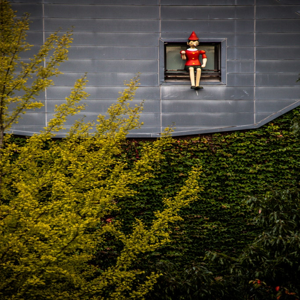

  ✅ Q: Is the main object a sculpture?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture a Pinocchio character?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture located outdoors?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture sitting on a window ledge?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture on the wall of a building?
     Expected: yes, Got: yes
  ❌ Q: Does the sculpture have a long nose?
     Expected: yes, Got: no
  ✅ Q: Is the sculpture wearing a hat?
     Expected: yes, Got: yes
  ✅ Q: Is the hat red and pointed?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture wearing a red shirt?
     Expected: yes, Got: yes
  ❌ Q: Is the sculpture wearing black shoes?
     Expected: yes, Got: no
  ✅ Q: Does the sculpture look like a wooden puppet?
     Expected: yes, Got: yes
  ❌ Q: Are the sculpture's legs hanging down?
     Expected: yes, Got: no
  ✅ Q: Does the sculpture have jointed arms?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture sitting inside a squ

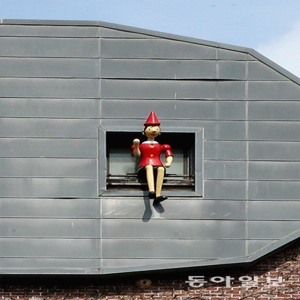

  ✅ Q: Is the main object a sculpture?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture a Pinocchio character?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture located outdoors?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture sitting on a window ledge?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture on the wall of a building?
     Expected: yes, Got: yes
  ✅ Q: Does the sculpture have a long nose?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture wearing a hat?
     Expected: yes, Got: yes
  ✅ Q: Is the hat red and pointed?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture wearing a red shirt?
     Expected: yes, Got: yes
  ❌ Q: Is the sculpture wearing black shoes?
     Expected: yes, Got: no
  ✅ Q: Does the sculpture look like a wooden puppet?
     Expected: yes, Got: yes
  ❌ Q: Are the sculpture's legs hanging down?
     Expected: yes, Got: no
  ✅ Q: Does the sculpture have jointed arms?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture sitting inside a sq

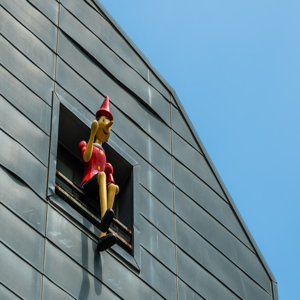

  ✅ Q: Is the main object a sculpture?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture a Pinocchio character?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture located outdoors?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture sitting on a window ledge?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture on the wall of a building?
     Expected: yes, Got: yes
  ✅ Q: Does the sculpture have a long nose?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture wearing a hat?
     Expected: yes, Got: yes
  ✅ Q: Is the hat red and pointed?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture wearing a red shirt?
     Expected: yes, Got: yes
  ❌ Q: Is the sculpture wearing black shoes?
     Expected: yes, Got: no
  ✅ Q: Does the sculpture look like a wooden puppet?
     Expected: yes, Got: yes
  ✅ Q: Are the sculpture's legs hanging down?
     Expected: yes, Got: yes
  ✅ Q: Does the sculpture have jointed arms?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture sitting inside a s

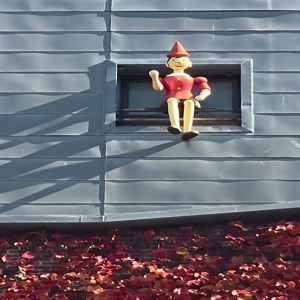

  ✅ Q: Is the main object a sculpture?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture a Pinocchio character?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture located outdoors?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture sitting on a window ledge?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture on the wall of a building?
     Expected: yes, Got: yes
  ❌ Q: Does the sculpture have a long nose?
     Expected: yes, Got: no
  ✅ Q: Is the sculpture wearing a hat?
     Expected: yes, Got: yes
  ✅ Q: Is the hat red and pointed?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture wearing a red shirt?
     Expected: yes, Got: yes
  ❌ Q: Is the sculpture wearing black shoes?
     Expected: yes, Got: no
  ✅ Q: Does the sculpture look like a wooden puppet?
     Expected: yes, Got: yes
  ✅ Q: Are the sculpture's legs hanging down?
     Expected: yes, Got: yes
  ✅ Q: Does the sculpture have jointed arms?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture sitting inside a sq

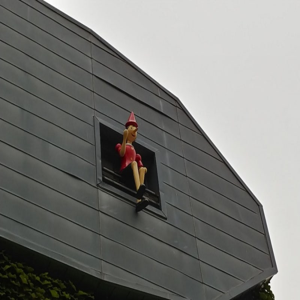

  ✅ Q: Is the main object a sculpture?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture a Pinocchio character?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture located outdoors?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture sitting on a window ledge?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture on the wall of a building?
     Expected: yes, Got: yes
  ❌ Q: Does the sculpture have a long nose?
     Expected: yes, Got: no
  ✅ Q: Is the sculpture wearing a hat?
     Expected: yes, Got: yes
  ✅ Q: Is the hat red and pointed?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture wearing a red shirt?
     Expected: yes, Got: yes
  ❌ Q: Is the sculpture wearing black shoes?
     Expected: yes, Got: no
  ✅ Q: Does the sculpture look like a wooden puppet?
     Expected: yes, Got: yes
  ❌ Q: Are the sculpture's legs hanging down?
     Expected: yes, Got: no
  ✅ Q: Does the sculpture have jointed arms?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture sitting inside a squ

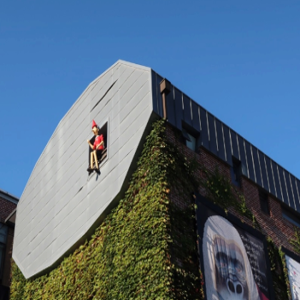

  ✅ Q: Is the main object a sculpture?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture a Pinocchio character?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture located outdoors?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture sitting on a window ledge?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture on the wall of a building?
     Expected: yes, Got: yes
  ❌ Q: Does the sculpture have a long nose?
     Expected: yes, Got: no
  ✅ Q: Is the sculpture wearing a hat?
     Expected: yes, Got: yes
  ✅ Q: Is the hat red and pointed?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture wearing a red shirt?
     Expected: yes, Got: yes
  ❌ Q: Is the sculpture wearing black shoes?
     Expected: yes, Got: no
  ✅ Q: Does the sculpture look like a wooden puppet?
     Expected: yes, Got: yes
  ❌ Q: Are the sculpture's legs hanging down?
     Expected: yes, Got: no
  ✅ Q: Does the sculpture have jointed arms?
     Expected: yes, Got: yes
  ❌ Q: Is the sculpture sitting inside a squ

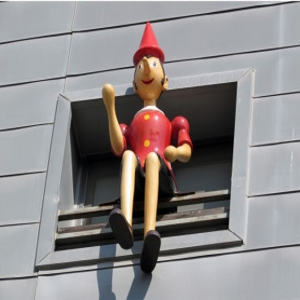

  ✅ Q: Is the main object a sculpture?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture a Pinocchio character?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture located outdoors?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture sitting on a window ledge?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture on the wall of a building?
     Expected: yes, Got: yes
  ✅ Q: Does the sculpture have a long nose?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture wearing a hat?
     Expected: yes, Got: yes
  ✅ Q: Is the hat red and pointed?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture wearing a red shirt?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture wearing black shoes?
     Expected: yes, Got: yes
  ✅ Q: Does the sculpture look like a wooden puppet?
     Expected: yes, Got: yes
  ❌ Q: Are the sculpture's legs hanging down?
     Expected: yes, Got: no
  ✅ Q: Does the sculpture have jointed arms?
     Expected: yes, Got: yes
  ✅ Q: Is the sculpture sitting inside a s

In [166]:
# --- 3. VQA 실행 및 True/False 평가 ---
image_results_list = []  # 이미지별 결과를 저장할 리스트

if total_questions_count > 0 and image_files:
    # tqdm을 사용하여 진행률 표시
    for img_path in tqdm(image_files, desc=f"'{'LANDMARK_NAME'}' 이미지 처리 중"):
        try:
            image = Image.open(img_path).convert("RGB")
            img_name = os.path.basename(img_path)

            print("\n" + "="*50)
            print(f"{img_name} 처리 중")
            print("="*50)

            # 이미지 표시 (Colab에서만)
            try:
                from IPython.display import display
                display(image.resize((300, 300)))
            except:
                pass

            true_count = 0
            false_count = 0
            false_questions_list = []  # False인 질문들 저장

            pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

            for question, expected_label in labeled_questions:
                inputs = processor(text=question, return_tensors="pt").to(device)

                out = model.generate(
                    pixel_values=pixel_values,
                    input_ids=inputs.input_ids,
                    attention_mask=inputs.attention_mask,
                    max_new_tokens=10
                )
                answer = processor.decode(out[0], skip_special_tokens=True).strip().lower()

                # True/False 판정
                is_correct = (answer == expected_label)
                status_icon = "✅" if is_correct else "❌"

                # 상세 로그 출력
                print(f"  {status_icon} Q: {question}")
                print(f"     Expected: {expected_label}, Got: {answer}")

                if is_correct:
                    true_count += 1
                else:
                    false_count += 1
                    false_questions_list.append({
                        "question": question,
                        "expected": expected_label,
                        "got": answer
                    })

            # --- 결과 계산 및 저장 ---
            true_ratio = (true_count / total_questions_count) if total_questions_count > 0 else 0.0
            is_success = true_ratio >= SUCCESS_THRESHOLD

            print(f"\n  [결과] True: {true_count}, False: {false_count}")
            print(f"  정확도: {true_ratio:.2%}")
            print(f"  성공 여부: {'✅ PASS' if is_success else '❌ FAIL'}")

            image_results_list.append({
                "image": img_name,
                "true_count": true_count,
                "false_count": false_count,
                "true_ratio": true_ratio,
                "is_success": is_success,
                "false_questions": false_questions_list,
                "total_questions": total_questions_count
            })

        except Exception as e:
            print(f"{img_path} 처리 중 오류 발생: {e}")

print("\n\n" + "="*50)
print(f"VQA 처리 완료. 'image_results_list' 변수에 {len(image_results_list)}개 결과 저장됨.")
print("="*50)

In [167]:
# --- 최종 요약 리스트 출력 ---

if 'image_results_list' not in locals() or not image_results_list:
    print("❌ 오류: 'image_results_list' 변수를 찾을 수 없습니다.")
    print("이전 셀을 먼저 실행하여 VQA 처리를 완료해주세요.")
else:
    print("\n" + "="*50)
    print(f"    '{LANDMARK_NAME}' VQA 이미지별 최종 평가 결과")
    print("="*50)

    total_accuracy = 0
    success_count = 0

    for result in image_results_list:
        print(f"\n이미지: {result['image']}")
        print(f"  - True  : {result['true_count']} / {result['total_questions']}")
        print(f"  - False : {result['false_count']}")
        print(f"  - 정확도: {result['true_ratio']:.2%}")
        print(f"  - 성공 여부: {'✅ PASS' if result['is_success'] else '❌ FAIL'}")

        # False 질문 목록 출력
        if result['false_questions']:
            print(f"\n  ❌ False 질문 목록 ({len(result['false_questions'])}개):")
            for i, fq in enumerate(result['false_questions'], 1):
                print(f"    {i}. Q: {fq['question']}")
                print(f"       Expected: {fq['expected']}, Got: {fq['got']}")

        print("-" * 50)

        total_accuracy += result['true_ratio']
        if result['is_success']:
            success_count += 1

    # 전체 통계
    avg_accuracy = total_accuracy / len(image_results_list)
    success_rate = success_count / len(image_results_list)

    print("\n" + "="*50)
    print("전체 통계")
    print("="*50)
    print(f"평균 정확도: {avg_accuracy:.2%}")
    print(f"성공 이미지: {success_count} / {len(image_results_list)} ({success_rate:.2%})")
    print(f"성공 임계값: {SUCCESS_THRESHOLD:.0%}")


    '창틀 피노키오' VQA 이미지별 최종 평가 결과

이미지: 9U6A2047.jpg
  - True  : 34 / 40
  - False : 6
  - 정확도: 85.00%
  - 성공 여부: ✅ PASS

  ❌ False 질문 목록 (6개):
    1. Q: Does the sculpture have a long nose?
       Expected: yes, Got: no
    2. Q: Is the sculpture wearing black shoes?
       Expected: yes, Got: no
    3. Q: Are the sculpture's legs hanging down?
       Expected: yes, Got: no
    4. Q: Is the sculpture waving one hand?
       Expected: yes, Got: no
    5. Q: Is the sculpture's face beige?
       Expected: yes, Got: no
    6. Q: Is the sky visible in the picture?
       Expected: yes, Got: no
--------------------------------------------------

이미지: 101991014.1.jpg
  - True  : 37 / 40
  - False : 3
  - 정확도: 92.50%
  - 성공 여부: ✅ PASS

  ❌ False 질문 목록 (3개):
    1. Q: Is the sculpture wearing black shoes?
       Expected: yes, Got: no
    2. Q: Are the sculpture's legs hanging down?
       Expected: yes, Got: no
    3. Q: Is the sculpture waving one hand?
       Expected: yes, Got: no
--------

In [168]:
import collections

# 모든 질문에 대한 총 정답 횟수를 저장할 딕셔너리
correct_answer_counts = collections.defaultdict(int)

# 총 질문 수 (모든 이미지에 대해 동일)
total_questions_per_image = total_questions_count

# 각 이미지를 순회하며 정답/오답 질문 업데이트
for result in image_results_list:
    # 현재 이미지에서 오답으로 판정된 질문들의 텍스트만 추출하여 집합으로 만듦
    false_question_texts = {fq['question'] for fq in result['false_questions']}

    # 해당 랜드마크의 모든 질문을 순회
    for question_text, _ in labeled_questions:
        # 만약 이 질문이 현재 이미지에서 오답 질문 목록에 없다면 정답으로 간주
        if question_text not in false_question_texts:
            correct_answer_counts[question_text] += 1

# 결과를 정답 횟수가 많은 순서로 정렬
sorted_correct_answers = sorted(correct_answer_counts.items(), key=lambda item: item[1], reverse=True)

print(f"\n{'='*50}")
print(f"랜드마크 '{LANDMARK_NAME}'의 질문별 정답 빈도 (총 이미지 수: {len(image_results_list)}개)")
print(f"{'='*50}")

# 결과 출력
if sorted_correct_answers:
    for question, count in sorted_correct_answers:
        print(f"  '{question}' : {count}회 (정답률: {count / len(image_results_list):.2%})")
else:
    print("정답으로 판정된 질문이 없습니다.")


랜드마크 '창틀 피노키오'의 질문별 정답 빈도 (총 이미지 수: 7개)
  'Is the main object a sculpture?' : 7회 (정답률: 100.00%)
  'Is the sculpture a Pinocchio character?' : 7회 (정답률: 100.00%)
  'Is the sculpture located outdoors?' : 7회 (정답률: 100.00%)
  'Is the sculpture sitting on a window ledge?' : 7회 (정답률: 100.00%)
  'Is the sculpture on the wall of a building?' : 7회 (정답률: 100.00%)
  'Is the sculpture wearing a hat?' : 7회 (정답률: 100.00%)
  'Is the hat red and pointed?' : 7회 (정답률: 100.00%)
  'Is the sculpture wearing a red shirt?' : 7회 (정답률: 100.00%)
  'Does the sculpture look like a wooden puppet?' : 7회 (정답률: 100.00%)
  'Does the sculpture have jointed arms?' : 7회 (정답률: 100.00%)
  'Is the building wall behind the sculpture gray?' : 7회 (정답률: 100.00%)
  'Is the sculpture colorful?' : 7회 (정답률: 100.00%)
  'Is the sculpture located indoors?' : 7회 (정답률: 100.00%)
  'Is the sculpture a real, living person?' : 7회 (정답률: 100.00%)
  'Is the sculpture an animal?' : 7회 (정답률: 100.00%)
  'Is the sculpture a cat?' : 7회 (정답률: 100.00